In [2]:
from nn_toxic_words_classifier import train_model
from nn_toxic_words_classifier import load_model

# model = train_model()
# Or load the weights:
model = load_model()

In [3]:
import pandas as pd

dataset_path = '/Users/damirabdulaev/Downloads/filtered.tsv'
df = pd.read_csv(dataset_path, sep='\t')
df = df[(df['similarity'] > 0.8) & (df['ref_tox'] > df['trn_tox'])]

In [4]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/damirabdulaev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
from nn_toxic_words_classifier import build_tokenizer
import string
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Extract and process the first 5 sentences
sentences = df['reference'].tolist()
tokenizer = build_tokenizer()[0]

# Define a threshold for toxic word prediction (adjust as needed)
toxic_threshold = 0.7
temp = 0

# Define a set of punctuation marks
punctuation_set = set(string.punctuation)

model.eval()

# Process and replace toxic words
for sentence in tqdm(sentences):
    encoded_dict = tokenizer(sentence)
    tokens = encoded_dict['input_ids']
    masked_sentence = []

    # Initialize a flag to exclude special tokens
    exclude_special_tokens = True

    for token in tokens:
        # Check if the token is a special token (CLS or SEP)
        is_special_token = token in (tokenizer.cls_token_id, tokenizer.sep_token_id)

        if exclude_special_tokens and is_special_token:
            continue  # Skip special tokens
        else:
            # Convert the token to an index using your vocabulary mapping
            inputs = torch.tensor([token], dtype=torch.long)
            with torch.no_grad():
                outputs = model(inputs)
                predicted_prob = outputs.item()
                # Check if the token is a punctuation mark
                is_punctuation = tokenizer.convert_ids_to_tokens(token) in punctuation_set
                if predicted_prob > toxic_threshold and not is_punctuation:
                    masked_sentence.append(103) # mask token
                else:
                    masked_sentence.append(token)

    # Use tokenizer.decode to reconstruct the sentence
    reconstructed_sentence = tokenizer.decode(masked_sentence)

    # Print the original sentence and the reconstructed sentence
    print("Original Sentence:")
    print(sentence)
    print("Reconstructed Sentence:")
    print(reconstructed_sentence)

    temp += 1
    if temp > 10:
        break

  0%|          | 10/108569 [00:00<01:00, 1794.97it/s]

Original Sentence:
Real life starts the first time you fuck, kid.
Reconstructed Sentence:
real life starts the first time you [MASK], kid.
Original Sentence:
Hey, leave the poor bastard alone!
Reconstructed Sentence:
hey, leave the [MASK] [MASK] [MASK]!
Original Sentence:
It told you this was a waste of my fucking time.
Reconstructed Sentence:
[MASK] told you this [MASK] [MASK] [MASK] of my [MASK] time.
Original Sentence:
I swear to God, the best thing I ever did in my life was save that little son of a bitch
Reconstructed Sentence:
i swear [MASK] god, the best [MASK] i ever did in my life [MASK] save that [MASK] [MASK] of [MASK] [MASK]
Original Sentence:
The guy is totally irresponsible.
Reconstructed Sentence:
the [MASK] is [MASK] ir [MASK]ponsible.
Original Sentence:
"Do you want to die?" he said.
Reconstructed Sentence:
" [MASK] you want [MASK] [MASK]? " [MASK] said.
Original Sentence:
Does anal...
Reconstructed Sentence:
[MASK] [MASK]...
Original Sentence:
Your girlfriends are dea

In [9]:
def get_non_toxic_synonym(word):
    synonyms = wordnet.synsets(word)
    if synonyms:
        valid_synonyms = [synonym.lemmas()[0].name() for synonym in synonyms if synonym.lemmas()[0].name() != word and synonym.lemmas()[0].name() != '[UNK]']
        if valid_synonyms:
            return valid_synonyms[0]
    return word  # If no valid synonyms found, return the original word

In [10]:
import string
import nltk
from nltk.corpus import wordnet

# Extract and process the first 5 sentences
sentences = df['reference'].tolist()
recon = []

# Define a threshold for toxic word prediction (adjust as needed)
toxic_threshold = 0.7
temp = 0

# Define a set of punctuation marks
punctuation_set = set(string.punctuation)

model.eval()

# Process and replace toxic words with synonyms
for sentence in tqdm(sentences):
    encoded_dict = tokenizer(sentence)
    tokens = encoded_dict['input_ids']
    replaced_sentence = []

    # Initialize a flag to exclude special tokens
    exclude_special_tokens = True

    for token in tokens:
        # Check if the token is a special token (CLS or SEP)
        is_special_token = token in (tokenizer.cls_token_id, tokenizer.sep_token_id)

        if exclude_special_tokens and is_special_token:
            continue  # Skip special tokens
        else:
            # Convert the token to an index using your vocabulary mapping
            inputs = torch.tensor([token], dtype=torch.long)
            with torch.no_grad():
                outputs = model(inputs)
                predicted_prob = outputs.item()
                # Check if the token is a punctuation mark
                is_punctuation = tokenizer.convert_ids_to_tokens(token) in punctuation_set
                if predicted_prob > toxic_threshold and not is_punctuation:
                    # Replace toxic word with a non-toxic synonym
                    word = tokenizer.convert_ids_to_tokens(token)
                    non_toxic_synonym = get_non_toxic_synonym(word)
                    if non_toxic_synonym in tokenizer.vocab:
                        for element in tokenizer(non_toxic_synonym)['input_ids'][1:-1]:
                            replaced_sentence.append(element)
                    else:
                        replaced_sentence.append(token)
                else:
                    replaced_sentence.append(token)

    # Use tokenizer.decode to reconstruct the sentence
    reconstructed_sentence = tokenizer.decode(replaced_sentence)

    # Print the original sentence and the reconstructed sentenc
    recon.append((sentence, reconstructed_sentence))

100%|██████████| 108569/108569 [01:01<00:00, 1755.73it/s]


In [11]:
import pickle
# Specify the filename for saving the list
file_name = 'recon.pkl'

# Save the list to a file using pickle
with open(file_name, 'wb') as file:
    pickle.dump(recon, file)

In [12]:
# Specify the filename from which to load the list
file_name = 'recon.pkl'

recon = []

# Load the list from the file using pickle
with open(file_name, 'rb') as file:
    recon = pickle.load(file)

In [13]:
for i, rec in enumerate(recon):
    print("Original sentence:", rec[0])
    print("Non-toxic sentence:", rec[1])
    if i == 10:
        break

Original sentence: Real life starts the first time you fuck, kid.
Non-toxic sentence: real life starts the first time you fuck, kid.
Original sentence: Hey, leave the poor bastard alone!
Non-toxic sentence: hey, leave the poor asshole entirely!
Original sentence: It told you this was a waste of my fucking time.
Non-toxic sentence: it told you this was a waste of my fuck time.
Original sentence: I swear to God, the best thing I ever did in my life was save that little son of a bitch
Non-toxic sentence: i swear to god, the best matter i ever did in my life was save that small son of a bitch
Original sentence: The guy is totally irresponsible.
Non-toxic sentence: the guy is wholly ir # # responsible.
Original sentence: "Do you want to die?" he said.
Non-toxic sentence: " bash you want to fail? " helium said.
Original sentence: Does anal...
Non-toxic sentence: does anal...
Original sentence: Your girlfriends are dead.
Non-toxic sentence: your girlfriends are dead.
Original sentence: Mikael

In [14]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/damirabdulaev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/damirabdulaev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Extract the pairs of sentences from the tuples
original = [sentence[0] for sentence in recon[:1000]]
detox = [sentence[1] for sentence in recon[:1000]]

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Combine the sentences for each array
original_sentences = [' '.join(sentence.split()) for sentence in original]
detox_sentences = [' '.join(sentence.split()) for sentence in detox]

# Fit and transform the sentences to TF-IDF vectors
original_tfidf = tfidf_vectorizer.fit_transform(original_sentences)
detox_tfidf = tfidf_vectorizer.transform(detox_sentences)

# Calculate cosine similarity for the corresponding sentences
cosine_similarities = cosine_similarity(original_tfidf, detox_tfidf)

cosine_similarity_sum = 0
for i, sim in enumerate(cosine_similarities):
    cosine_similarity_sum += sim[i]

print("Mean cosine similarity of the original and detox sentences:", cosine_similarity_sum / len(cosine_similarities))

Mean cosine similarity of the original and detox sentences: 0.8215615626705213


In [16]:
from J_metric import J

result = J(original, detox)  # Call the J function with appropriate arguments

Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:30<00:00, 32.37it/s]


0.3469421966112059
Calculate the semantic similarity
0.8252710278630256
Calculating CoLA acceptability stats


  0%|          | 0/1000 [00:00<?, ?it/s]

0.9271976281367242
| ACC | SIM | FL | J |

|0.3469|0.8253|0.9272|0.2655|



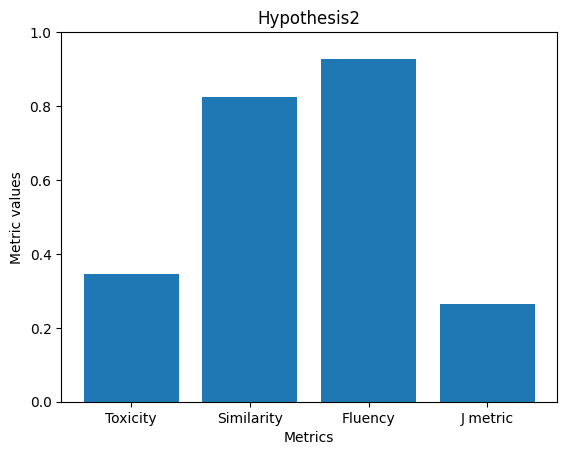

In [17]:
from bar_chart_for_metric import build_chart

data = [0.3469, 0.8253, 0.9272, 0.2655]

build_chart(data, "Hypothesis2", '/Users/damirabdulaev/Desktop/Hypothesis2.png')